<a href="https://colab.research.google.com/github/AshishRaj04/Projects-and-Exercises-of-Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlo/blob/main/Chapter_2_End_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I have tried to implement the project of predicting median housing price from the book and I will also solve the exercise problem.

# Download the dataset


In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path("dataset/housing.tgz")
  if not tarball_path.is_file():
    Path("dataset").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="dataset")

  return pd.read_csv("dataset/housing/housing.csv")

housing = load_housing_data()

#Taking a quick look at the data

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


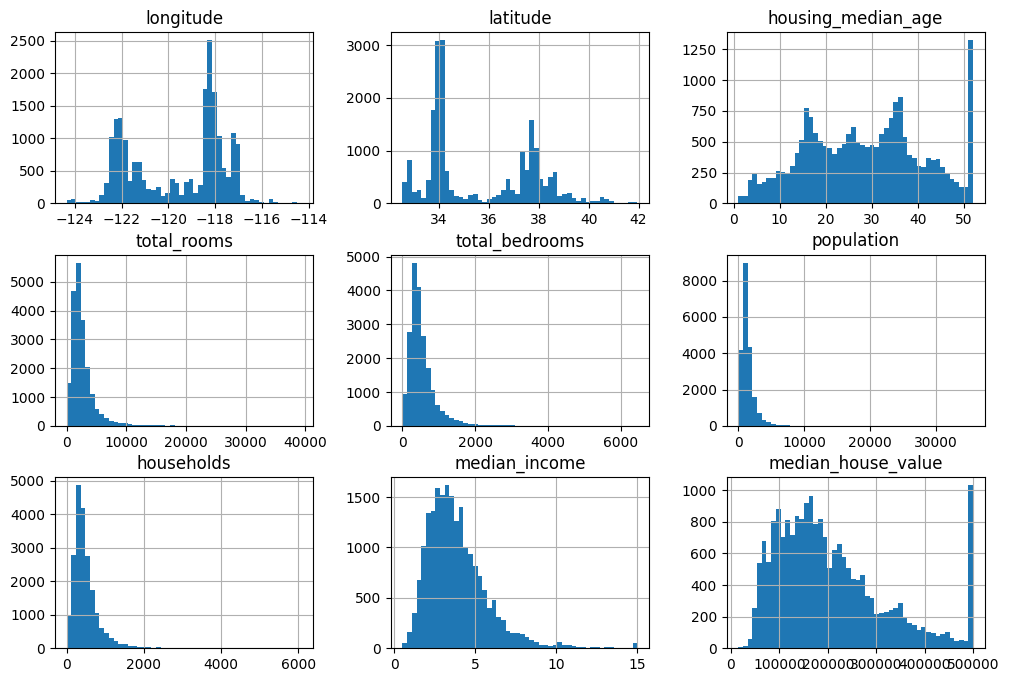

In [6]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12 , 8))
plt.show()

# **Insights from visualization of the data**


1.   10 features - 9 numeric(float64) 1 object
2.   total_bathrooms is missing some values
3. median income 1 = 10000 USD
   median age , median house value are also capped
4. Many features are skewed right



# Creating the test set

## Key ideas

* Creating a test set using random
sampling would not reflect the true unbiased estimate as the median income is the most important feature in predicting the median housing value . But the median income is skewed to the right . **Sampling Bias** would occure if we generate test set using random sampling

* We have to use stratified smapling based on income category.

* We will use `StratifiedShuffleSplit` class from ` sklearn.model_selection`.
We will create 10 different splits for better estimation of the performance of the model.

* `.split()` method return indices .

* Use `train_test_split` if you only want one split (this is often the case) -
```python
trat_train_set, strat_test_set = train_test_split(
 housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)
 ```

In [7]:
import numpy as np

In [9]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins = [0 , 1.5 , 3.0 , 4.5 , 6.0 , np.inf],
                                       labels= [1,2,3,4,5])

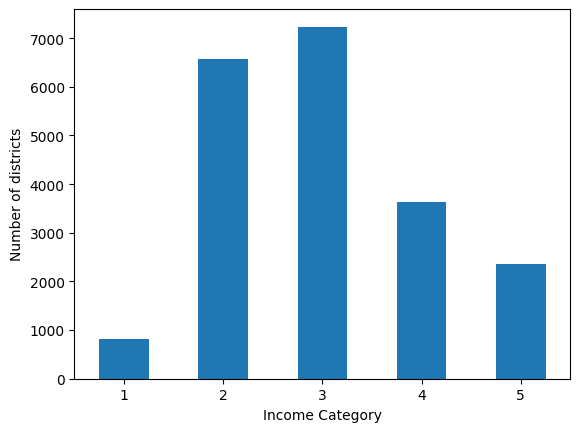

In [10]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=10 , test_size=0.2,random_state=42)
stratified_sample_splits = []
for train_idx , test_idx in splitter.split(housing , housing["income_cat"]):
  strat_train_set = housing.loc[train_idx]
  strat_test_set = housing.loc[test_idx]
  stratified_sample_splits.append((strat_train_set , strat_test_set))

In [12]:
strat_train_set , strat_test_set = stratified_sample_splits[0]

# Visualize the data

First of all make a copy of the traning set

In [13]:
housing_train_set = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

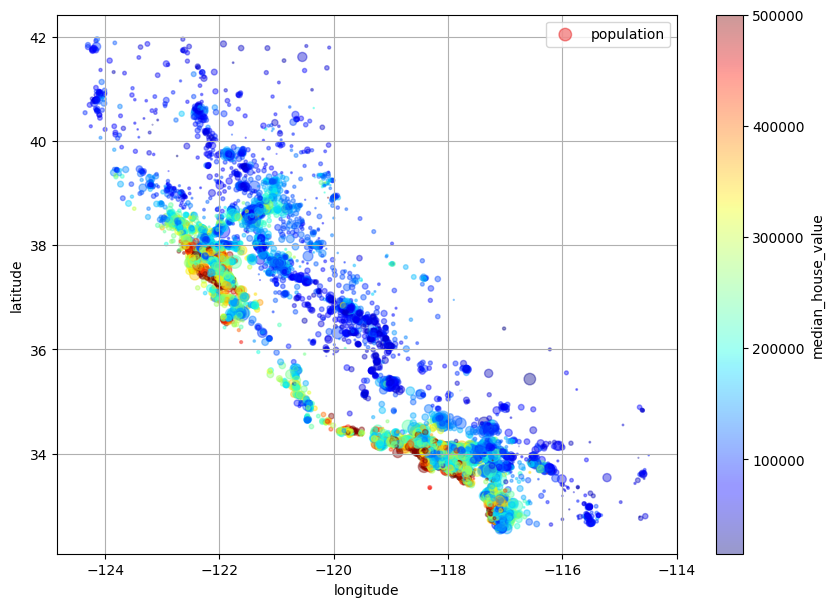

In [14]:
housing_train_set.plot(
    kind = "scatter",
    x = "longitude",
    y = "latitude",
    alpha = 0.4,
    s = housing_train_set["population"]/100,
    label = "population",
    c = "median_house_value",
    cmap = "jet",
    colorbar = True,
    legend = True,
    sharex = False,
    figsize = (10,7),
    grid = True
)

## Looking for correlation

In [15]:
housing_train_num = housing_train_set.drop("ocean_proximity" , axis = 1)

#OR

#housing_train_num = housing_train_set.select_dtypes(include = [np.number])

In [16]:
corr_matrix = housing_train_num.corr()

In [17]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688380
income_cat            0.642887
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

# Feature Engineering

In [18]:
housing_train_num["rooms_per_house"] = housing_train_num["total_rooms"]/housing_train_num["households"]
housing_train_num["bedrooms_ratio"] = housing_train_num["total_bedrooms"]/housing_train_num["total_rooms"]
housing_train_num["people_per_house"] = housing_train_num["population"]/housing_train_num["households"]

In [19]:
corr_matrix = housing_train_num.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688380
income_cat            0.642887
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

So we have created features that correlate better with the median housing value.

# **Before applying transformation**

* Build libraries of transformation function
* These functions can be used on new data
* Transformation won't apply to target lable

In [23]:
housing_num_features = housing_train_num.drop("median_house_value" , axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Clean the missing data

* We will use `sklearn` `SimpleImputer`
* It calculate the median by `strategy="median"` and put the median value of each feature into the missing values if any.
* This is an example of transformation by Simple Imputer transformer
* Transformer return array so we need to convert it back to data frame
```python
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
 index=housing_num.index)

```

In [24]:
housing_num_features_only = housing_num_features.select_dtypes(include = [np.number])

In [22]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num_features_only)

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.12500000e+03,
        4.34000000e+02,  1.16700000e+03,  4.08000000e+02,  3.53850000e+00,
        5.23557310e+00,  2.03105786e-01,  2.82231619e+00])

In [ ]:
housing_num_features_only.median().values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.12500000e+03,
        4.34000000e+02,  1.16700000e+03,  4.08000000e+02,  3.53850000e+00,
        5.23557310e+00,  2.03105786e-01,  2.82231619e+00])

In [ ]:
X = imputer.transform(housing_num_features_only)

In [ ]:
# housing_tr = pd.DataFrame(X, columns=housing_num_features_only.columns,
#  index=housing_num_features_only.index)

# Handling Text and Categorical Attributes

We will use one hot encoding

In [25]:
from sklearn.preprocessing import OneHotEncoder

# category_encoder = OneHotEncoder()
# housing_cat_1hot = category_encoder.fit_transform(housing_train_set[["ocean_proximity"]])
# housing_cat_1hot

In [ ]:
# housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
# category_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#**Feature Scaling and Transformation**

## Custom Transformers
* Transform heavy tailed distributions with their log
* Transform multimodal distributions with *Gaussian RBF*

In [26]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel

In [27]:
log_transformer = FunctionTransformer(np.log , inverse_func = np.exp)
# log_population = log_transformer.transform(housing_num_features[["population"]])

In [28]:
rbf_transformer = FunctionTransformer(
    rbf_kernel ,
    kw_args=dict(Y=[[35.]],gamma=0.1))

# age_simil_35 = rbf_transformer.transform(
#     housing_num_features[["housing_median_age"]]
# )

In [29]:
sqrt_transformer = FunctionTransformer(np.sqrt , inverse_func = np.square)

#**Transformation Pipelines**

*

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer , make_column_selector
from sklearn.preprocessing import StandardScaler

In [31]:
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
 "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

In [32]:
cat_pipeline = Pipeline([
    ("cat_imputer" , SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(handle_unknown="ignore")),

])
num_pipeline = Pipeline([
    ("num_imputer" , SimpleImputer(strategy="median")),
    ("std_scaler" , StandardScaler()),

])

preprocessing_pipeline = ColumnTransformer([
    ("num_pipeline" , num_pipeline , make_column_selector(dtype_include = np.number)),
    ("cat_pipeline" , cat_pipeline , make_column_selector(dtype_include = object))
])

In [ ]:
# housing_features = housing_num_features.join(housing_train_set[["ocean_proximity"]])

In [ ]:
# housing_prepared = preprocessing_pipeline.fit_transform(housing_features)

In [33]:
housing_train_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [34]:
housing_train_dataset = housing_train_set.drop("median_house_value" , axis=1)

In [35]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

# Function to name the output feature of the ratio transformation
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

# Ratio pipeline
def ratio_pipeline():
    return Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('ratio_transformer', FunctionTransformer(column_ratio, feature_names_out=ratio_name)),
        ('scaler', StandardScaler())
    ])

# Log transformation pipeline
log_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('log_transformer', FunctionTransformer(np.log, feature_names_out="one-to-one")),
    ('scaler', StandardScaler())
])

# RBF kernel transformation pipeline
rbf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler()),
    ('rbf_transformer', FunctionTransformer(
        rbf_kernel,
        kw_args=dict(Y=[[2.3, 2.2, 1.8]], gamma=0.1),
        feature_names_out="one-to-one"
    ))
])

# Default numerical pipeline for remaining columns
default_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

# Complete preprocessing pipeline
preprocessing = ColumnTransformer([
    ("bedrooms_ratio", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house_ratio", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house_ratio", ratio_pipeline(), ["population", "households"]),
    ("log_transform", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("rbf_transform", rbf_pipeline, ["latitude", "longitude", "housing_median_age"]),
    ("categorical", cat_pipeline, make_column_selector(dtype_include=object)),
],
remainder=default_num_pipeline)

In [36]:
housing_prepared = preprocessing.fit_transform(housing_train_dataset)

In [37]:
from sklearn import set_config

set_config(display='diagram')

preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                             SimpleImputer(strategy='median')),
                                            ('scaler', StandardScaler())]),
                  transformers=[('bedrooms_ratio',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('ratio_transformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x77fdbc8a5090>,
                                                                      func=<function column_ratio at 0x77fdbc8a5000...
                                                                      func=<function rbf_kernel at 0x77fdbce70ca0>,
                                                                      kw_args={'Y': [[2.3,
                                                                                      2.2,
                                                                                      1.8]],
                                                                               'gamma': 0.1}))]),
                                 ['latitude', 'longitude',
                                  'housing_median_age']),
                                ('categorical',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x77fdbc838790>)])

In [38]:
housing_prepared.shape

(16512, 15)

In [39]:
preprocessing.get_feature_names_out()

array(['bedrooms_ratio__ratio', 'rooms_per_house_ratio__ratio',
       'people_per_house_ratio__ratio', 'log_transform__total_bedrooms',
       'log_transform__total_rooms', 'log_transform__population',
       'log_transform__households', 'log_transform__median_income',
       'rbf_transform__latitude', 'rbf_transform__longitude',
       'rbf_transform__housing_median_age',
       'categorical__ocean_proximity_<1H OCEAN',
       'categorical__ocean_proximity_INLAND',
       'categorical__ocean_proximity_ISLAND',
       'categorical__ocean_proximity_NEAR BAY',
       'categorical__ocean_proximity_NEAR OCEAN', 'remainder__income_cat'],
      dtype=object)

In [55]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out()[:15],
    index=housing_num_features_only.index
)
housing_prepared_fr.head(2)

,bedrooms_ratio__ratio,rooms_per_house_ratio__ratio,people_per_house_ratio__ratio,log_transform__total_bedrooms,log_transform__total_rooms,log_transform__population,log_transform__households,log_transform__median_income,rbf_transform__latitude,rbf_transform__longitude,rbf_transform__housing_median_age,categorical__ocean_proximity_<1H OCEAN,categorical__ocean_proximity_INLAND,categorical__ocean_proximity_ISLAND,categorical__ocean_proximity_NEAR BAY
13096,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,0.227981,0.0,0.0,0.0,1.0,0.0,-0.954687
14973,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,0.289949,1.0,0.0,0.0,0.0,0.0,1.890078


# Train a Model
Since we are done with feature transformation we are now ready for traning a model as see how it is performing.

`housing_label` is the labeled data we have.

## Linear Regression

In [40]:
from sklearn.linear_model import LinearRegression

In [61]:
lin_reg = Pipeline([
    ("preprocessing" , preprocessing),
    ("lin_reg_model" , LinearRegression())
])

lin_reg.fit(housing_train_dataset , housing_labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('scaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratio_transformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x77fdbc8a5090>,
                                                                                       func=<fun...
                                                                                       kw_args={'Y': [[2.3,
                                                                                                       2.2,
                                                                                                       1.8]],
                                                                                                'gamma': 0.1}))]),
                                                  ['latitude', 'longitude',
                                                   'housing_median_age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x77fdbc838790>)])),
                ('lin_reg_model', LinearRegression())])

In [45]:
housing_prediction = lin_reg.predict(housing_train_dataset)

In [62]:
housing_prediction[:5].round(-2)

array([248000., 386500.,  91600.,  92900., 314600.])

In [63]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

- RANDOM FOREST REGRESSOR

In [69]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
forest_reg = Pipeline([
    ("preprocessing" , preprocessing),
    ("forest_reg_model" , RandomForestRegressor())
])

forest_reg.fit(housing_train_dataset , housing_labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('scaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratio_transformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x77fdbc8a5090>,
                                                                                       func=<fun...
                                                                                       kw_args={'Y': [[2.3,
                                                                                                       2.2,
                                                                                                       1.8]],
                                                                                                'gamma': 0.1}))]),
                                                  ['latitude', 'longitude',
                                                   'housing_median_age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x77fdbc838790>)])),
                ('forest_reg_model', RandomForestRegressor())])

In [74]:
forest_predictin = forest_reg.predict(housing_train_dataset)

In [75]:
forest_predictin[:5].round(-2)

array([401600., 485100., 103500.,  98400., 384500.])

In [76]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

# Performance Measure
- ROOT MEAN SQUARE ERROR

In [64]:
from sklearn.metrics import mean_squared_error

In [65]:
lin_rmse = mean_squared_error(housing_labels , housing_prediction , squared = False)
lin_rmse

71719.00266193935

In [77]:
for_rmse = mean_squared_error(housing_labels , forest_predictin , squared = False)
for_rmse

22040.101108314786

## Evaluation using cross-validation

In [66]:
from sklearn.model_selection import cross_val_score

- Evaluation for lin_reg

In [67]:
lin_rmse = -cross_val_score(
    lin_reg,
    housing_train_dataset,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10,
)

In [68]:
pd.Series(np.sqrt(lin_rmse)).describe()

count       10.000000
mean     72652.223954
std       3141.557385
min      69046.208725
25%      70862.533911
50%      71945.689012
75%      73161.031424
max      80450.524539
dtype: float64

* Evaluation for forest_reg

In [71]:
forest_rmse = -cross_val_score(
    forest_reg,
    housing_train_dataset,
    housing_labels,
    scoring="neg_root_mean_squared_error",
    cv=10,
)

In [72]:
pd.Series(forest_rmse).describe()

count       10.000000
mean     58938.494670
std       1091.447988
min      57359.527729
25%      58510.372770
50%      58801.666178
75%      59508.712725
max      60873.151837
dtype: float64

# Fine Tune The Model
* Grid Search
* Randomized Search

In [78]:
from sklearn.model_selection import GridSearchCV

In [94]:
full_pipeline = Pipeline([
    ("preprocessing" , preprocessing),
    ("linear_regressor" , LinearRegression())
])

param_grid = [
    {
        "linear_regressor__fit_intercept" : [True , False],
        "linear_regressor__n_jobs" : [1 , 2 , 3 , 4 , 5],
        "linear_regressor__positive" : [True , False],
        "linear_regressor__copy_X" : [True , False],
        # "preprocessing__rbf_transform__gamma" : [2 , 1.5, 2.2 , 2.8 , 1 , 2.50 , 1.8],
        "preprocessing__categorical__cat_imputer__strategy" : ["most_frequent" , "constant"],
        "preprocessing__categorical__cat_encoder__handle_unknown" : ["error" , "ignore" , "default"]
    },

]

In [95]:
grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
)

In [96]:
grid_search.fit(housing_train_dataset , housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('scaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms_ratio',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ratio_transformer',
                                                                                          FunctionTransformer(feature_names_out=<function ratio_nam...
                          'linear_regressor__fit_intercept': [True, False],
                          'linear_regressor__n_jobs': [1, 2, 3, 4, 5],
                          'linear_regressor__positive': [True, False],
                          'preprocessing__categorical__cat_encoder__handle_unknown': ['error',
                                                                                      'ignore',
                                                                                      'default'],
                          'preprocessing__categorical__cat_imputer__strategy': ['most_frequent',
                                                                                'constant']}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [97]:
grid_search.best_params_

{'linear_regressor__copy_X': True,
 'linear_regressor__fit_intercept': True,
 'linear_regressor__n_jobs': 1,
 'linear_regressor__positive': False,
 'preprocessing__categorical__cat_encoder__handle_unknown': 'error',
 'preprocessing__categorical__cat_imputer__strategy': 'most_frequent'}

In [98]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('scaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratio_transformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x77fdbc8a5090>,
                                                                                       func=<fun...
                                                                                       func=<function rbf_kernel at 0x77fdbce70ca0>,
                                                                                       kw_args={'Y': [[2.3,
                                                                                                       2.2,
                                                                                                       1.8]],
                                                                                                'gamma': 0.1}))]),
                                                  ['latitude', 'longitude',
                                                   'housing_median_age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x77fdc695dae0>)])),
                ('linear_regressor', LinearRegression(n_jobs=1))])

# Looking for the best model

In [101]:
final_model = grid_search.best_estimator_
print(final_model)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('scaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratio_transformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x77fdbc8a5090>,
                                                                                       func=<fun...
                                                           

In [102]:
coef  = final_model["linear_regressor"].coef_
coef

array([  15939.47921516,    6110.5134156 ,    7721.76983263,
        -25184.61824041,   12307.57180495,  -78448.54527131,
         92224.05340295,   42412.95964681,  142615.8233372 ,
        -40338.77958065, -116457.55305423,  212012.34625604,
        -29006.64626759,  -26209.36735357,   30786.89004329])

In [103]:
sorted(
    zip(final_model["preprocessing"].get_feature_names_out(), coef),
    key=lambda x: abs(x[1]),
    reverse=True

)

[('categorical__ocean_proximity_<1H OCEAN', 212012.34625603847),
 ('rbf_transform__latitude', 142615.82333719634),
 ('rbf_transform__housing_median_age', -116457.55305423301),
 ('log_transform__households', 92224.05340294517),
 ('log_transform__population', -78448.54527130844),
 ('log_transform__median_income', 42412.9596468113),
 ('rbf_transform__longitude', -40338.77958064647),
 ('categorical__ocean_proximity_NEAR BAY', 30786.890043288007),
 ('categorical__ocean_proximity_INLAND', -29006.646267587894),
 ('categorical__ocean_proximity_ISLAND', -26209.36735357128),
 ('log_transform__total_bedrooms', -25184.618240409844),
 ('bedrooms_ratio__ratio', 15939.479215163154),
 ('log_transform__total_rooms', 12307.571804954403),
 ('people_per_house_ratio__ratio', 7721.76983263243),
 ('rooms_per_house_ratio__ratio', 6110.513415601592)]

# Evaluate the final model in the test set

In [104]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

77970.52337624462


# Saving the model

In [105]:
import joblib

In [106]:
joblib.dump(final_model , "my_model.pkl")

['my_model.pkl']

# Loading the model

In [107]:
# final_model_loaded = joblib.load("my_model.pkl")
# new_data = [....]
# prediction = final_model_loaded.predict(new_data)